In [4]:
# load the necessary modules
import numpy as np
import argparse
import pandas as pd
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torchmetrics
from torchmetrics import Metric
from torchmetrics import MeanSquaredError, Accuracy, MeanAbsoluteError
from torch import embedding
from torch.utils.data import Dataset, DataLoader, IterableDataset
from sklearn import model_selection, preprocessing, metrics
import matplotlib.pyplot as plt
import random

In [5]:
#extracting ratings from text file into a data frame
df = pd.DataFrame()
# df = pd.read_csv('ratings.csv', encoding='utf-8')
df=pd.read_table('ratings.txt', delimiter = '::')
df.head(3)

D:\Masters\Semester1\Machine Learning\Machine Learning\Codes\ay7aga\venv\lib\site-packages\pandas\io\parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [6]:
#preprocessing

# keeping only column that we want by droping timestamp column
df = df[['user_id','movie_id','rating']]

user_label_encoder  = preprocessing.LabelEncoder()
movie_label_encoder = preprocessing.LabelEncoder()
df.user_id  =  user_label_encoder.fit_transform(df.user_id.values)
df.movie_id =  movie_label_encoder.fit_transform(df.movie_id.values)
num_users =  len(user_label_encoder.classes_)
num_movies = len(movie_label_encoder.classes_)


# keeping only column that we want by droping timestamp column
train_ratings = df.sample(frac=0.8) 
test_ratings  = df.drop(train_ratings.index)

train_users  = train_ratings.user_id.values 
train_movies = train_ratings.movie_id.values
train_labels = train_ratings.rating.values 

train_users  = torch.tensor(train_users) 
train_movies = torch.tensor(train_movies) 
train_labels = torch.tensor(train_labels)

In [7]:
# a global variable that is initialized every training 
loss_history = []

In [8]:
# defining the dataset class for our model

class MoviesDataSet(Dataset):
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    def __len__(self):
        return len(self.users)
    def __getitem__(self, idx):
        return  self.users[idx] , self.movies[idx],  self.ratings[idx]  
        

In [19]:
# defining our collaborative filtering model

class CollaborativeFiltering(pl.LightningModule):
    def __init__(self, num_users, num_movies, user_training_tensor, movie_training_tensor, label_training_tensor,batch_size):
        super().__init__()
        self.users_tensor = user_training_tensor
        self.movies_tensor = movie_training_tensor
        self.labels_tensor = label_training_tensor
        
        
        self.user_embedding  = torch.nn.Embedding(num_embeddings = num_users, embedding_dim =32)
        self.movie_embedding = torch.nn.Embedding(num_embeddings = num_movies, embedding_dim =32)
        self.output = torch.nn.Linear(64, 1)
        
        self.batch_size = batch_size
        
        # defining some metrics attributes
        self.MSE = MeanSquaredError()
        self.MAE = MeanAbsoluteError()
        self.epoch_loss = 0
        loss_history.clear() ##initiate loss history global variable
        
        
    def forward(self, user_input, movie_input):
        user_embedded = self.user_embedding(user_input)
        movie_embedded = self.movie_embedding(movie_input) 
        emb_vector    = torch.cat([user_embedded,movie_embedded], dim=1)
        pred = self.output(emb_vector)
        return pred

    def training_step(self, batch, batch_idx):
        user_input, movie_input, labels = batch
        batch_size = len(user_input)

        predicted_labels = self.forward(user_input, movie_input)
        labels = labels[:,None]
        loss = torch.nn.MSELoss()(predicted_labels, labels.view(-1,1).float())
        self.MSE(predicted_labels, labels.view(-1,1).float())
        mse =  self.MSE(predicted_labels, labels.view(-1,1).float())
        mae =  self.MAE(predicted_labels, labels.view(-1,1).float())
        
        self.log('mean_absolute_error', mae, prog_bar=True)
        self.log('mean_squared_error', mse, prog_bar=True)
        self.log('batch-size', batch_size, prog_bar=True)
        self.log('epoch', self.current_epoch, prog_bar=True)

        epoch = self.current_epoch+1.0
        self.log('epoch', epoch, prog_bar=True)
        self.epoch_loss = loss.cpu().detach().numpy()
        
        return loss
    
    def training_epoch_end(self, training_step_outputs):
        array = np.array(self.epoch_loss)
        loss_history.append(self.epoch_loss)
        print(self.epoch_loss)

         

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    
    def train_dataloader(self):

        return DataLoader(MoviesDataSet(self.users_tensor, self.movies_tensor, self.labels_tensor),batch_size =self.batch_size)

In [11]:
# instanciating our collaborative filtering model from the defined class
# model = CollaborativeFiltering(num_users, num_movies, train_users, train_movies, train_labels)

In [12]:
# loss_history = tensor.detach.numpy(loss_history)
def plot():
    loss = np.array(loss_history)
    plt.plot(loss)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Cost function")
    plt.show()

In [13]:
# utilizing our model to make predictions

moviesIds  = df['movie_id'].unique() #id must be inserted encoded also 
user_item_set = set(zip(df.user_id,df.movie_id)) # we need to use here the full range of ids 
users_interactions = df.groupby('user_id')['movie_id'].apply(list).to_dict()

def get_user_pred_list(user):
    user_interactions = list(users_interactions[user])
    new_items_to_user = list(set(moviesIds)-set(user_interactions))
    random_selected_new = list(np.random.choice(list(new_items_to_user), 99))
    predicted_labels = np.squeeze(model(torch.tensor([user]*(len(random_selected_new))),
                                   torch.tensor(random_selected_new)).detach().numpy())
    top_5 = [random_selected_new[i] for i in np.argsort(predicted_labels)[::-1][0:5].tolist()]
    predicted_movies_index = np.argsort(predicted_labels)
    print("Movies recommendation list:")
    for i in range(0,5):
        print(f"Movie's id:{top_5[i]+1}")

Enter the number of epochs:50
Enter the batch-size:32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params
------------------------------------------------------
0 | user_embedding  | Embedding         | 193 K 
1 | movie_embedding | Embedding         | 118 K 
2 | output          | Linear            | 65    
3 | MSE             | MeanSquaredError  | 0     
4 | MAE             | MeanAbsoluteError | 0     
------------------------------------------------------
311 K     Trainable params
0         Non-trainable params
311 K     Total params
1.248     Total estimated model params size (MB)
D:\Masters\Semester1\Machine Learning\Machine Learning\Codes\ay7aga\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

0.6158009
0.6224493
0.6138378
0.60314476


D:\Masters\Semester1\Machine Learning\Machine Learning\Codes\ay7aga\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


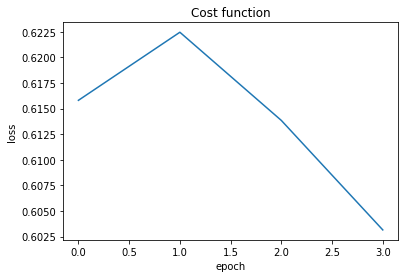

In [20]:
ep = input("Enter the number of epochs:")
bs = input("Enter the batch-size:")
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

model = CollaborativeFiltering(num_users, num_movies, train_users, train_movies, train_labels, int(bs))

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

trainer = pl.Trainer(max_epochs=int(ep))
trainer.fit(model)
plot()

In [15]:
print(loss_history)

[array(0.6158009, dtype=float32), array(0.6224493, dtype=float32), array(0.6138378, dtype=float32)]


In [18]:
user = input("Enter the user's id:")
get_user_pred_list(int(user)-1) ### because the model was trained on dataset in which the users and movies
                                        ### were indexed begining from 0 (where id 1->0)

Enter the user's id:3
Movies recommendation list:
Movie's id:310
Movie's id:853
Movie's id:3703
Movie's id:1019
Movie's id:209
